# Definir componentes

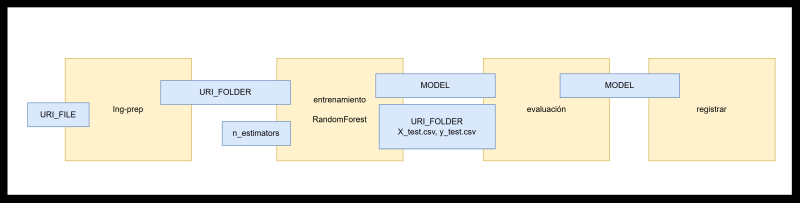

In [ ]:
pip show azure-ai-ml

## Conectar a workspace

In [ ]:
# conectar
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())

print(f"Conectado al Workspace: {ml_client.workspace_name}")

## Crear los directorios

In [ ]:
import os

# create a folder for the script files
script_folder = './src'
os.makedirs(script_folder, exist_ok=True)

os.makedirs(f'{script_folder}/train-rf-model', exist_ok=True)
os.makedirs(f'{script_folder}/eval-model', exist_ok=True)
os.makedirs(f'{script_folder}/register-model', exist_ok=True)

print(script_folder, 'folders created')

## Definir componentes

### training

In [ ]:
%%writefile ./src/train-rf-model/train-rf-model.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import argparse
from pathlib import Path

import mlflow
import glob


def main(args):
    mlflow.autolog()

    df = get_data(args.input_data)
    model, X_test, y_test = train_model('price', df, args.n_estimators, 0.3)

    mlflow.sklearn.save_model(model, args.model_output)

    X_test.to_csv((Path(args.output_data) / "housing_X_test.csv"), index = False)
    y_test.to_csv((Path(args.output_data) / "housing_y_test.csv"), index = False)

    

def get_data(data_path):

    all_files = glob.glob(data_path + "/*.csv")
    df = pd.concat((pd.read_csv(f) for f in all_files), sort=False)
    
    return df


def train_model(target, data, n_estimators, test_size=0.2):
    # 4. Separar características (X) y objetivo (y)
    X = data.drop(columns=[target])  # Todas las columnas excepto target
    y = data[target]  # Variable objetivo

    # 5. Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    # 6. Preprocesamiento de datos
    # Identificar columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Crear un preprocesador con StandardScaler para numéricas y OneHotEncoder para categóricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    # 7. Crear un pipeline con el preprocesador y el modelo rf
    mlflow.log_param("n_estimators:", n_estimators)

    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        # n_estimators es el parámetro de regularización
        ('regressor', RandomForestRegressor(n_estimators=n_estimators, random_state=42))
    ])

    # 8. Entrenar el modelo
    rf_model.fit(X_train, y_train)

    return rf_model, X_test, y_test


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", dest='input_data', type=str)
    parser.add_argument("--n_estimators", dest='n_estimators', type=int, default=0.01)
    
    parser.add_argument("--model_output", dest='model_output',type=str)
    parser.add_argument("--output_data", dest='output_data',type=str)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    print('args:', args)
    main(args)

In [ ]:
%%writefile train-rf-model.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: train_rf_model_housing
display_name: Entrenamiento de Modelo Random Forest
version: 2
type: command
inputs:
  input_data: 
    type: uri_folder
  n_estimators:
    type: number
    default: 100
outputs:
  model_output:
    type: mlflow_model
  output_data:
    type: uri_folder
code: ./src/train-rf-model/
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python train-rf-model.py
  --input_data ${{inputs.input_data}}
  --n_estimators ${{inputs.n_estimators}}
  --model_output ${{outputs.model_output}}
  --output_data ${{outputs.output_data}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

train_rf_model = load_component(source="train-rf-model.yml")

reg_train_rf_model = ml_client.components.create_or_update(train_rf_model)
reg_train_rf_model

### evaluación evalucionada

In [ ]:
%%writefile ./src/eval-model/eval-model.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import json

import argparse
from pathlib import Path

import mlflow


def main(args):
    mlflow.autolog()

    model = mlflow.sklearn.load_model(args.model_input)
    X_test, y_test = get_data(args.input_data)
    evaluate_model(model, X_test, y_test)


def get_data(data_path):
    X_test = pd.read_csv((Path(data_path) / "housing_X_test.csv"))
    y_test = pd.read_csv((Path(data_path) / "housing_y_test.csv"))

    return X_test, y_test


def evaluate_model(a_model, X_test, y_test):
    # 9. Hacer predicciones
    y_pred = a_model.predict(X_test)

    # 10. Evaluar el modelo usando MSE
    mse = mean_squared_error(y_test, y_pred)
    print(f"Error Cuadrático Medio (MSE): {mse:.2f}")

    # 11. Calcular la varianza de los datos objetivo
    variance = np.var(y_test.values)
    print(f"Varianza de los datos objetivo: {variance:.2f}")

    # 12. Comparación entre MSE y varianza
    mse_to_variance_ratio = mse / variance
    print(f"Relación MSE/Varianza: {mse_to_variance_ratio:.2f}")

    with mlflow.start_run():
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mse2var", mse_to_variance_ratio)
        mlflow.sklearn.log_model(a_model, "model")

    # Guardar las métricas en un archivo JSON
    save_metrics(mse, mse_to_variance_ratio, args.metrics_output)


def save_metrics(mse, mse_to_variance_ratio, output_path):
    metrics = {
        "mse": mse,
        "mse_to_variance_ratio": mse_to_variance_ratio
    }
    
    with open(output_path, "w") as f:
        json.dump(metrics, f)



def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_input", dest='model_input', type=str, required=True)
    parser.add_argument("--input_data", dest='input_data', type=str, required=True)
    parser.add_argument("--metrics_output", type=str, required=True)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    print('args:', args)
    main(args)

In [ ]:
%%writefile eval-model.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: eval_model_metrics
display_name: Evaluación de Modelo y exposición de Métricas
version: 2
type: command
inputs:
  input_data: 
    type: uri_folder
  model_input:
    type: mlflow_model
outputs:
  metrics_output:
    type: uri_file
code: ./src/eval-model/
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python eval-model.py
  --input_data ${{inputs.input_data}}
  --model_input ${{inputs.model_input}}
  --metrics_output ${{outputs.metrics_output}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

eval_model = load_component(source="eval-model.yml")

reg_eval_model = ml_client.components.create_or_update(eval_model)
reg_eval_model

### registro

#### crear environment personalizado

In [ ]:
%%writefile src/environment/conda-env.yml
name: sklearn-azure-ai-env
channels:
  - defaults
  - conda-forge
dependencies:
  - python=3.11
  - pip
  - scikit-learn
  - pandas
  - numpy
  - matplotlib
  - pip:
    - azure-ai-ml
    - azure-identity
    - mlflow
    - mltable
    - jsonschema
    - pathlib

In [ ]:
# Crear entorno
from azure.ai.ml.entities import Environment

env_docker_image = Environment(
    name="sklearn-azure-ai-env",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    conda_file="src/environment/conda-env.yml",
    description="Environment created from a Azure ML Docker image.",
    version="4"
)

ml_client.environments.create_or_update(env_docker_image)

#### crear componente

In [ ]:
%%writefile ./src/register-model/register-model.py

import pandas as pd
import numpy as np
import json

import argparse
from pathlib import Path

import mlflow

from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model
from azure.identity import DefaultAzureCredential


def main(args):
    mlflow.autolog()

    metrics = read_metrics(args.metrics_input)
    register_model(args.model_input, metrics, args.model_name)


def read_metrics(data_path):
    # Leer las métricas desde el archivo
    with open(data_path, "r") as f:
        metrics = json.load(f)

    print(f"Métricas leídas:", metrics)

    return metrics


def register_model(model_path, metrics, model_name):
    # Inicializar el cliente de Azure ML
    ml_client = MLClient.from_config(credential=DefaultAzureCredential())

    mse = metrics['mse']
    mse_to_variance_ratio = metrics['mse_to_variance_ratio']
    threshold = 0.98

    # Registrar el modelo
    if mse_to_variance_ratio < threshold:
        registered_model = ml_client.models.create_or_update(
            Model(
                path=model_path,
                name=model_name,
                description=f"Modelo registrado con accuracy={mse}"
            )
        )
        print(f"Modelo {model_name} registrado con éxito.") 

    else:
        print(f"mse_to_variance_ratio ({mse_to_variance_ratio}) no supera el umbral ({threshold}). El modelo no será registrado ni desplegado.")




def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_input", dest='model_input', type=str, required=True)
    parser.add_argument("--metrics_input", dest='metrics_input', type=str, required=True)
    parser.add_argument("--model_name", dest='model_name', type=str, required=True)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    print('args:', args)
    main(args)

In [ ]:
%%writefile register-model.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: register_conditional_model
display_name: Registro condicional del modelo
version: 10
type: command
inputs:
  metrics_input:
    type: uri_file
  model_input:
    type: mlflow_model
  model_name:
    type: string
code: ./src/register-model/
environment: azureml:sklearn-azure-ai-env:4
command: >-
  python register-model.py
  --metrics_input ${{inputs.metrics_input}}
  --model_input ${{inputs.model_input}}
  --model_name ${{inputs.model_name}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

register_model = load_component(source="register-model.yml")

reg_register_model = ml_client.components.create_or_update(register_model)
reg_register_model